In [2]:
%matplotlib notebook
import matplotlib.pyplot as pl
from astropy.io import fits
from ngmix.medsreaders import NGMixMEDS
import numpy as np
import galsim
import fitsio

import sys
sys.path.insert(0,'/Users/secco/Documents/projects/delve_shear/delve_cs_test/code/newish_metacal/tests')
sys.path.insert(0,'/Users/secco/Documents/projects/delve_shear/delve_cs_test/code/newish_metacal')
sys.path.insert(0,'/Users/secco/Documents/projects/delve_shear/delve_cs_test/code/newish_metacal/metacal')

import test_metacal

medsname = '/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits'

In [48]:
def plot_object(filename,obj_ind,colorbar=False):
    m = fitsio.FITS(filename)
    ncutout = m[1]['ncutout'][obj_ind]
    
    #to get the image, weight, bmask and seg:
    box_size = m[1]['box_size'][obj_ind]
    start_rows = m[1]['start_row'][obj_ind]
    
    print(start_rows)
    
    #to get the PSF
    psf_row_sizes = m[1]['psf_row_size'][obj_ind]
    psf_col_sizes = m[1]['psf_row_size'][obj_ind]
    psf_start_rows = m[1]['psf_start_row'][obj_ind]
    np.testing.assert_array_equal(psf_row_sizes,psf_col_sizes)
    
    Nrows=5 #image, bmask, seg, weight
    
    pl.figure(figsize=(10,2*ncutout))
    for cutout in np.arange(ncutout)+1: #loop over the cutouts
        start_row = start_rows[cutout-1]
        end_row = start_row+box_size**2
        
        psf_start_row = psf_start_rows[cutout-1]
        psf_box_size = psf_row_sizes[cutout-1]
        psf_end_row = psf_start_row + psf_box_size**2
        
        pl.subplot(Nrows,ncutout,cutout)
        pl.imshow(m['image_cutouts'][start_row:end_row].reshape(box_size,box_size))
        pl.title('cutout %d'%cutout)
        if cutout==1:
            pl.ylabel('Image',rotation=0)
        if colorbar:
            pl.colorbar()
        
        pl.subplot(Nrows,ncutout,cutout+ncutout)
        pl.imshow(m['weight_cutouts'][start_row:end_row].reshape(box_size,box_size))
        if cutout==1:
            pl.ylabel('Weight',rotation=0)
        if colorbar:
            pl.colorbar()
        
        pl.subplot(Nrows,ncutout,cutout+2*ncutout)
        pl.imshow(m['seg_cutouts'][start_row:end_row].reshape(box_size,box_size))
        if cutout==1:
            pl.ylabel('Seg',rotation=0)
        if colorbar:
            pl.colorbar()
        
        pl.subplot(Nrows,ncutout,cutout+3*ncutout)
        pl.imshow(m['bmask_cutouts'][start_row:end_row].reshape(box_size,box_size))
        if cutout==1:
            pl.ylabel('bmask',rotation=0)
        if colorbar:
            pl.colorbar()
        
        pl.subplot(Nrows,ncutout,cutout+4*ncutout)
        pl.imshow(m['psf'][psf_start_row:psf_end_row].reshape(psf_box_size,psf_box_size))
        if cutout==1:
            pl.ylabel('PSF',rotation=0)
        if colorbar:
            pl.colorbar()
        
    m.close()    
    pl.show()
    

# Write simple stuff into the MEDS file

Before creating the simulations, let's get the metadata (like image size, jacobians and etc) from the MEDS file

In [36]:
#the info() method of astropy is still pretty good for an overview...
m_astropy = fits.open(medsname)
m_astropy.info()
print(m_astropy[1].header['NAXIS2'])

#now read and do things using fitsio 
m = fitsio.FITS(medsname,mode='rw')
print(m[1])

Filename: /Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  object_data    1 BinTableHDU     77   28586R x 33C   [K, K, D, D, K, 11K, 11K, 11D, 11D, 11K, 11K, 11D, 11D, 11D, 11D, 11D, 11D, K, J, E, E, E, E, E, E, E, D, D, 11J, 11J, 11D, 11D, 11K]   
  2  image_info    1 BinTableHDU     43   44R x 16C   [45A, 4A, 45A, 4A, 45A, 4A, 45A, 4A, 45A, 4A, 38A, K, E, E, D, 2338A]   
  3  metadata      1 BinTableHDU     35   1R x 12C   [D, 10A, 4A, 1358A, 8A, 1A, 12A, 6A, 5A, 8A, 5A, 5A]   
  4  image_cutouts    1 ImageHDU        16   (333934592,)   float32   
  5  weight_cutouts    1 ImageHDU        16   (333934592,)   float32   
  6  seg_cutouts    1 ImageHDU        13   (333934592,)   int32   
  7  bmask_cutouts    1 ImageHDU        13   (333934592,)   int32   
  8  psf           1 ImageHDU        16   (344139578,) 

Accessing things in the file with fitsio seems simple:

In [37]:
obj_ind=300
box_size = m['object_data']['box_size'][obj_ind]
ncutout = m[1]['ncutout'][obj_ind]
start_row = m[1]['start_row'][obj_ind]

cutout_row = m[1]['cutout_row'][obj_ind]
cutout_col = m[1]['cutout_col'][obj_ind]
orig_start_row = m[1]['orig_start_row'][obj_ind]

psf_row = m[1]['psf_row_size'][obj_ind]
psf_col = m[1]['psf_col_size'][obj_ind]
psf_start_row = m[1]['psf_start_row'][obj_ind]

psf_cutout_row = m[1]['psf_cutout_row'][obj_ind] 

print(box_size)
print(ncutout)
print(start_row)
print(psf_row)

32
2
[1796096 1797120   -9999   -9999   -9999   -9999   -9999   -9999   -9999
   -9999   -9999]
[   43    43 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999]


# Easily plot objects:

[2305280 2306304 2307328   -9999   -9999   -9999   -9999   -9999   -9999
   -9999   -9999]


<IPython.core.display.Javascript object>


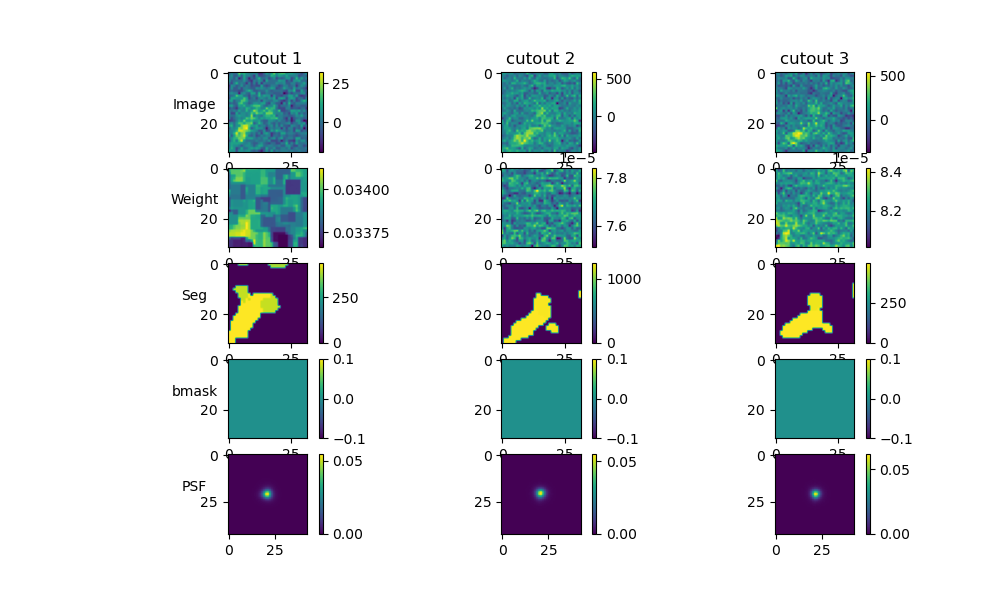

In [65]:
plot_object(medsname,400,colorbar=True)

[27193856 27194880 27195904    -9999    -9999    -9999    -9999    -9999
    -9999    -9999    -9999]


<IPython.core.display.Javascript object>


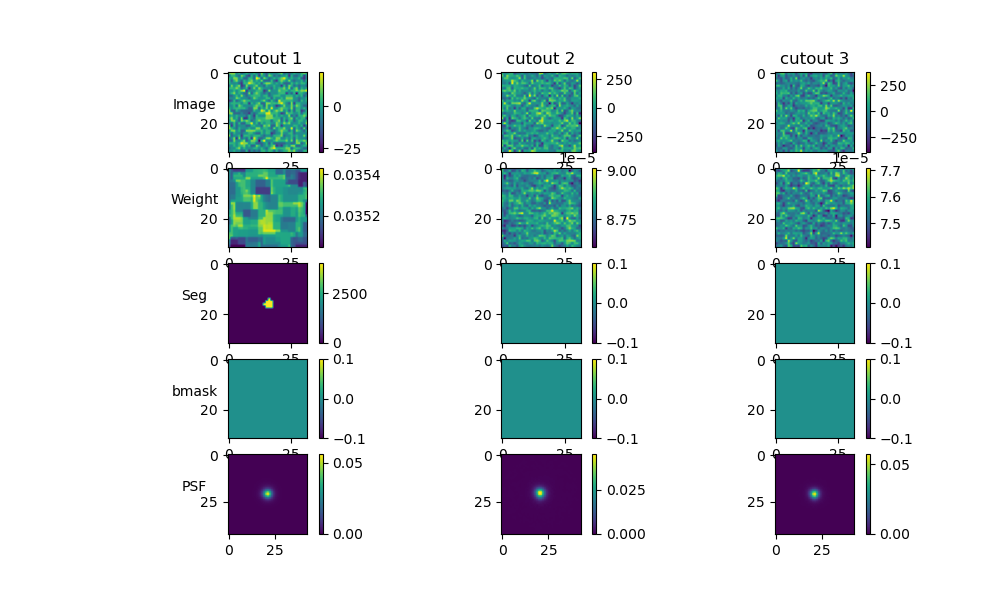

In [80]:
plot_object(medsname,4001,colorbar=True)

# Try writing to a file

In [23]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
b = pl.imread('/Users/secco/Desktop/bird.png')
b_gray = rgb2gray(b)*100 #need to multiply by a large number otherwise the compression destroys the image... kinda weird

obj_ind = 4001
cutout_ind = 1
start_row = m[1]['start_row'][obj_ind][cutout_ind]
box_size = m[1]['box_size'][obj_ind]
end_row = start_row+box_size**2
print(m['image_cutouts'])
m['image_cutouts'].write(b_gray.ravel(), start_row) 
print(m['image_cutouts'])
m.close()


  file: /Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits
  extension: 4
  type: IMAGE_HDU
  extname: image_cutouts
  image info:
    data type: f4
    dims: [333934592]

  file: /Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits
  extension: 4
  type: IMAGE_HDU
  extname: image_cutouts
  image info:
    data type: f4
    dims: [333934592]


[27193856 27194880 27195904    -9999    -9999    -9999    -9999    -9999
    -9999    -9999    -9999]


<IPython.core.display.Javascript object>


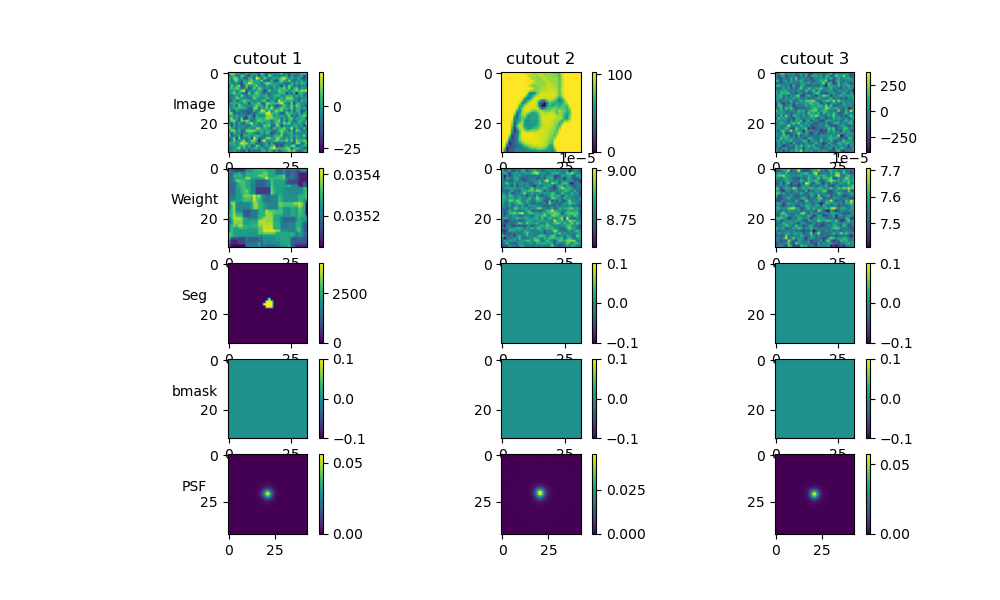

In [27]:
plot_object(medsname,4001,colorbar=True)

OK so things are working, even though the compression vs. decompression of the file is causing some issues

Let's simulate some galaxies now

# Create simple image sims and write them up in the MEDS file

`test_metacal.py` has the basic functions to create a simulation (the func called `make_sim`), let's  copy that down here and start modifying it

In [ ]:
'''
def make_sim(*, seed, g1, g2):
    rng = np.random.RandomState(seed=seed)

    gal = galsim.Exponential(half_light_radius=0.5).shear(g1=g1, g2=g2)
    psf = galsim.Gaussian(fwhm=0.9)
    obj = galsim.Convolve([gal, psf])
    dim = 53
    cen = (dim-1)/2
    dither = rng.uniform(size=2, low=-0.5, high=0.5)
    scale = 0.263

    im = obj.drawImage(nx=53, ny=53, offset=dither, scale=scale).array
    nse = np.sqrt(np.sum(im**2)) / 1e6
    im += rng.normal(size=im.shape, scale=nse)

    psf_im = psf.drawImage(nx=53, ny=53, scale=scale).array

    jac = ngmix.DiagonalJacobian(
        scale=scale, row=cen+dither[0], col=cen+dither[1]
    )
    psf_jac = ngmix.DiagonalJacobian(
        scale=scale, row=cen, col=cen
    )

    obs = ngmix.Observation(
        image=im,
        weight=np.ones_like(im) / nse**2,
        jacobian=jac,
        bmask=np.zeros_like(im, dtype=np.int32),
        psf=ngmix.Observation(
            image=psf_im,
            jacobian=psf_jac,
        ),
        meta={"orig_row": cen, "orig_col": cen},
    )
    return ngmix.observation.get_mb_obs(obs)
'''

Here's what I'll try to do:

In [39]:
def flux_to_mag(F):
    return -2.5*np.log10(F)+30.0

def mag_to_flux(m):
    return 10**(-0.4*(m-30))

def make_sim_one_cutout(*, seed, g1, g2, open_meds, obj_ind, cutout):
    m = open_meds        
    #rng = np.random.RandomState(seed=seed)
    gal = galsim.Exponential(half_light_radius=0.5).shear(g1=g1, g2=g2) #let's do sheared exponentials again
    
    #fwhm=rng.uniform(low=0.8,high=1.5) #will use a random FWHM for each sim just because
    fwhm=np.random.uniform(low=0.8,high=1.5)
    psf = galsim.Gaussian(fwhm=fwhm) 
    obj = galsim.Convolve([gal, psf]) 
    
    dim = m[1]['box_size'][obj_ind] #size of the image box
    
    cutout_row = m[1]['cutout_row'][obj_ind][cutout]
    cutout_col = m[1]['cutout_col'][obj_ind][cutout]
    #dither = np.random.uniform(size=2, low=-0.5, high=0.5)
    #scale = 0.263 #the size of a DECam pixel in arcsec on the sky 
    
    #get WCS:
    #jacobian: column in MEDS is x, row is y
    dudx = m[1]['dudcol'][obj_ind][cutout]
    dudy = m[1]['dudrow'][obj_ind][cutout]
    dvdx = m[1]['dvdcol'][obj_ind][cutout]
    dvdy = m[1]['dvdrow'][obj_ind][cutout]
    wcs = galsim.JacobianWCS(dudx, dudy, dvdx, dvdy)
    #from matt: drawImage(nx=stampsize, ny=stampsize, wcs=jac_wcs, center=galsim.PositionD(x=cutout_col, y=cutout_row))
    #flux = m[1].data['flux'][obj_ind]
    im = obj.drawImage(nx=dim, ny=dim,  wcs=wcs, center=galsim.PositionD(x=cutout_col, y=cutout_row)).array * mag_to_flux(18.0) #multiplying by flux here, is that what I really want?
    
    im_start_row = m[1]['start_row'][obj_ind][cutout]
    im_end_row = im_start_row + dim**2
    weight=m[5][im_start_row:im_end_row].reshape(dim,dim) #get the weight of each cutout, will use this to add noise to the simulated image
    nse=np.sqrt(1.0/weight)
    #im += rng.normal(size=im.shape, scale=nse)
    im += np.random.normal(size=im.shape, scale=nse)

 
    psf_row = m[1]['psf_row_size'][obj_ind][cutout] #size of the PSF (rows) for each cutout
    psf_col = m[1]['psf_col_size'][obj_ind][cutout] #size of the PSF (cols) for each cutout
    assert psf_row==psf_col, "PSF is not a square, which they say is not cool"
    
    psf_start_row = m[1]['psf_start_row'][obj_ind][cutout]
    psf_end_row = psf_start_row + psf_row*psf_col
    psf_im = psf.drawImage(nx=psf_row, ny=psf_col, wcs=wcs).array
    
    return im.ravel(), psf_im.ravel(), im_start_row, im_end_row, psf_start_row, psf_end_row
    #To do: stop ignoring bmask


def replace_all_cutouts_by_sims(input_medsname, verbose=False):
    m = fitsio.FITS(input_medsname,mode='rw') #opens the input file
    Nobjects = m[1].get_nrows() #gets number of objects (rows) in the file
    for i_obj in range(Nobjects): #loops over objects in the file
        Ncutout = m[1]['ncutout'][i_obj] 
        if verbose and i_obj%1000==0: print("Object %d has %d cutouts to be replaced"%(i_obj,Ncutout))
        for j_cut in range(Ncutout): #loops over cutout in each object in the file
            im, psf, im_start, im_end, psf_start, psf_end = make_sim_one_cutout(seed=10, g1=0.5, g2=0.00, 
                                                                                    open_meds=m, obj_ind=i_obj, cutout=j_cut)
                
            m['image_cutouts'].write(im, im_start) 
            m['psf'].write(psf, psf_start)
    m.close()

### Now write the entire file

In [41]:
input_medsname = '/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits'

replace_all_cutouts_by_sims(input_medsname=input_medsname,verbose=True)

Object 0 has 2 cutouts to be replaced


/Users/secco/opt/anaconda3/envs/delve_shear/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/Users/secco/opt/anaconda3/envs/delve_shear/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


Object 1000 has 4 cutouts to be replaced
Object 2000 has 4 cutouts to be replaced
Object 3000 has 4 cutouts to be replaced
Object 4000 has 4 cutouts to be replaced
Object 5000 has 4 cutouts to be replaced
Object 6000 has 3 cutouts to be replaced
Object 7000 has 3 cutouts to be replaced
Object 8000 has 3 cutouts to be replaced
Object 9000 has 7 cutouts to be replaced
Object 10000 has 8 cutouts to be replaced
Object 11000 has 3 cutouts to be replaced
Object 12000 has 11 cutouts to be replaced
Object 13000 has 8 cutouts to be replaced
Object 14000 has 11 cutouts to be replaced
Object 15000 has 11 cutouts to be replaced
Object 16000 has 8 cutouts to be replaced
Object 17000 has 9 cutouts to be replaced
Object 18000 has 10 cutouts to be replaced
Object 19000 has 9 cutouts to be replaced
Object 20000 has 4 cutouts to be replaced
Object 21000 has 7 cutouts to be replaced
Object 22000 has 7 cutouts to be replaced
Object 23000 has 2 cutouts to be replaced
Object 24000 has 8 cutouts to be replac

#### Before modifying the file 

[34397440 34398464 34399488 34400512    -9999    -9999    -9999    -9999
    -9999    -9999    -9999]


<IPython.core.display.Javascript object>


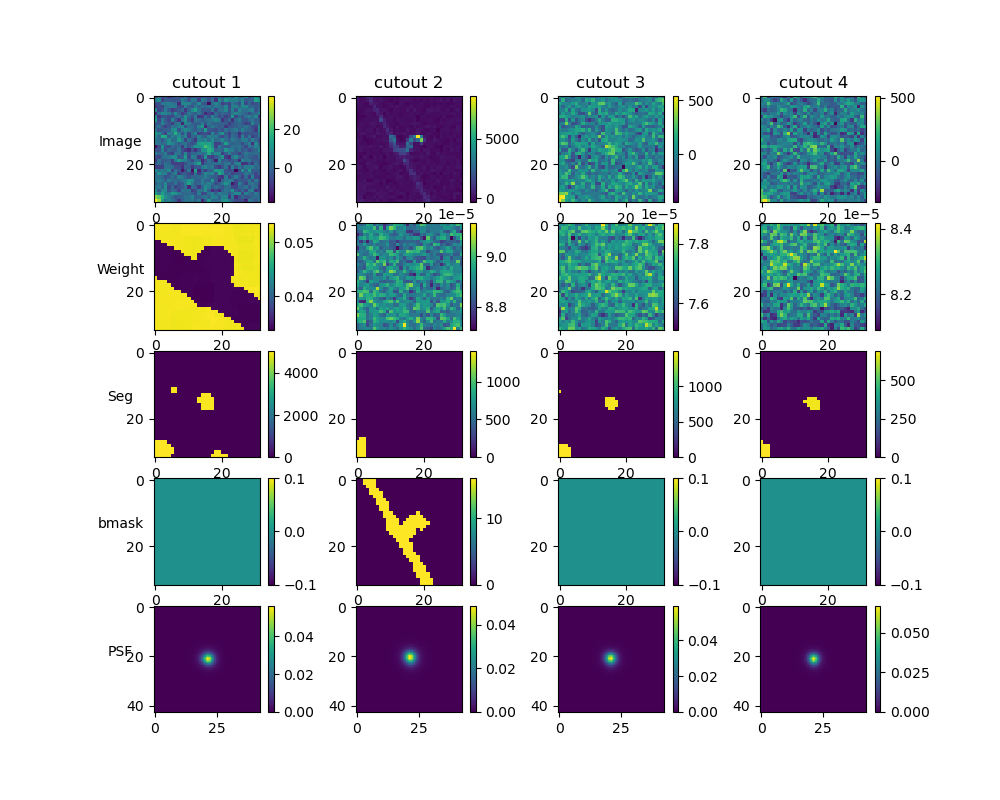

In [54]:
medsname='/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/DES0954+0252_r4918p01_i_meds-DECADE.fits'
plot_object(medsname,5000,colorbar=True)

#### After modifying the file

[34397440 34398464 34399488 34400512    -9999    -9999    -9999    -9999
    -9999    -9999    -9999]


<IPython.core.display.Javascript object>


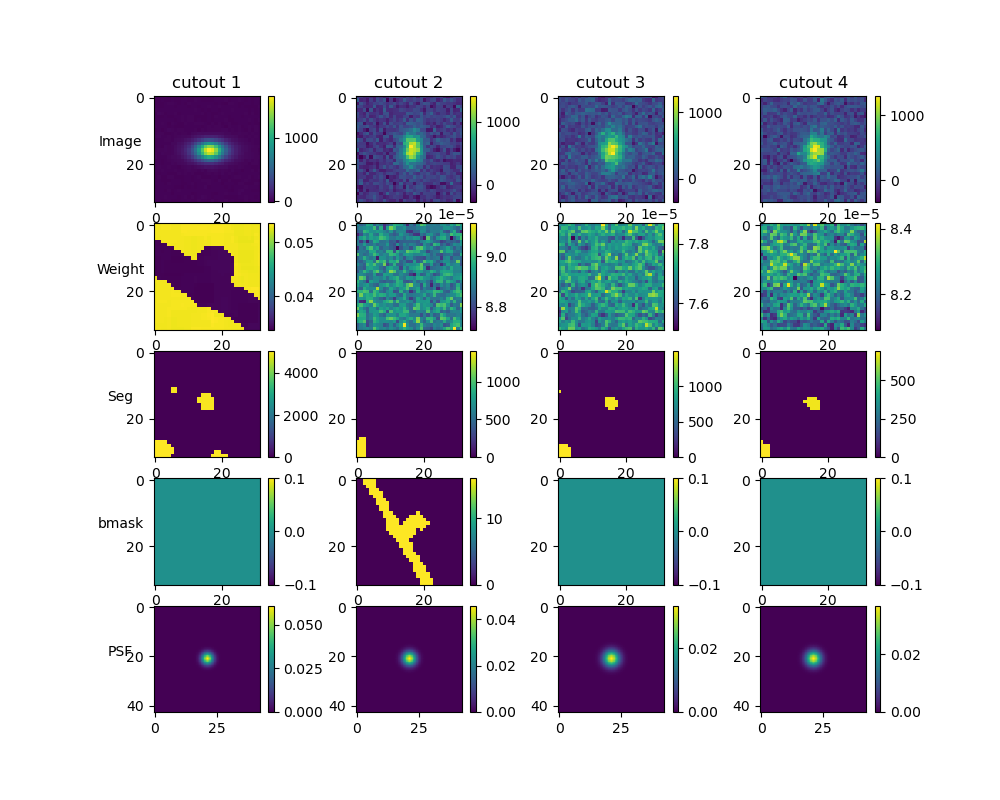

In [55]:
medsname='/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits'
plot_object(medsname,5000,colorbar=True)

In [63]:
equals230 = m['bmask_cutouts'][:]==2**30

In [64]:
np.sum(equals230)

418912